In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df=pd.read_excel("D:\ExcelR Data Science\Assignments\Forecasting\Airlines+Data.xlsx",sheet_name='Sheet1')

In [3]:
df.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [5]:
df.shape

(96, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


There are 96 records and 2 columns and no null values present

Now we need to index mOnth Column


In [11]:
df1= df.set_index('Month',inplace=False)

In [12]:
df1

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


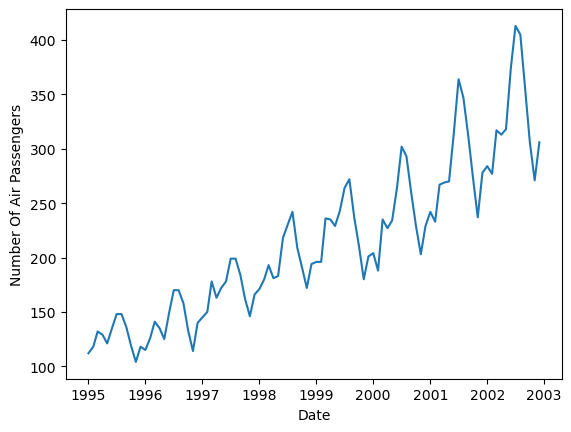

In [13]:
# Plot the data


plt.xlabel('Date')
plt.ylabel('Number Of Air Passengers')
plt.plot(df1)

From the above below, we can see that there is a Trend compoenent in the series. Hence, we now check for stationarity of the data.

Let's make one function consisting of stationary data checking and ADCF test working. 
Because we will need to repeat the steps many times, therefore, making function will become very handy

In [14]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    airpass_test = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(airpass_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in airpass_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

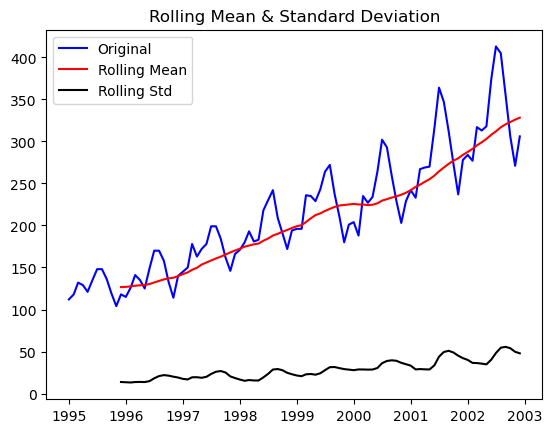

Results of Dickey Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [15]:
# plot rlling statistics

test_stationarity(df1)

For time series to be stationary, we need to ensure that both Rolling Mean and Rolling Standard Deviation remain fairly constant WRT time.

Both the curves needs to be parallel to X-Axis, in our case it is not so.

For a Time series to be stationary, the ADCF test should have:

      p-value should be low (according to the null hypothesis)
      The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics
From the above ADCF test result, we can see that p-value(near to 1.0) is very large. Also critical values are no where close to the Test Statistics. Hence, we can safely say that our Time Series at the moment is NOT STATIONARY

### Data Transformation To Achieve Stationarity
     
       Now, we will have to perform some data transformation to achieve Stationarity. We can perform any of the transformations like taking log scale, square, square root, cube, cube root, time shift, exponential decay, etc.



In [16]:
df1_log=np.log(df1)

In [17]:
df1_log

,Passengers
Month,
1995-01-01,4.718499
1995-02-01,4.770685
1995-03-01,4.882802
1995-04-01,4.859812
1995-05-01,4.795791
...,...
2002-08-01,6.003887
2002-09-01,5.872118
2002-10-01,5.723585


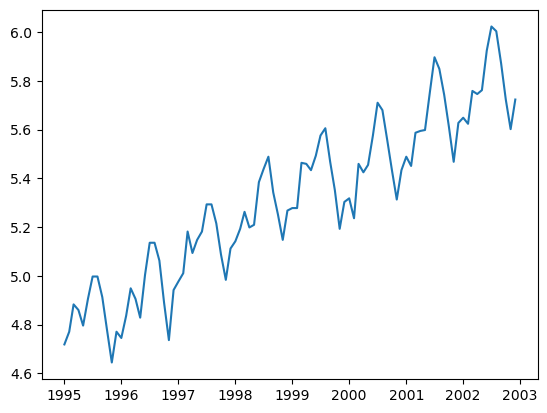

In [18]:
plt.plot(df1_log)

In [19]:
rollmean_log = df1_log.rolling(window=12).mean()
rollstd_log = df1_log.rolling(window=12).std()

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation (Logarithmic Scale)')

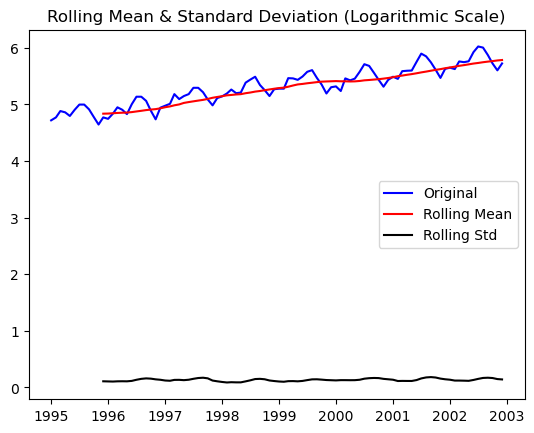

In [20]:
plt.plot(df1_log, color='blue', label='Original')
plt.plot(rollmean_log, color='red', label='Rolling Mean')
plt.plot(rollstd_log, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (Logarithmic Scale)')

From above graph we can say that, we slightly bettered our previous results.
From the above graph, Time series with log scale as well as Rolling Mean(moving avg) both have the trend component. Thus subtracting one from the other should remove the trend component.

In [21]:
df_new=df1_log-rollmean_log

In [22]:
df_new

,Passengers
Month,
1995-01-01,NaN
1995-02-01,NaN
1995-03-01,NaN
1995-04-01,NaN
1995-05-01,NaN
...,...
2002-08-01,0.258591
2002-09-01,0.116062
2002-10-01,-0.041675


In [23]:
#droping NAN values
df_new.dropna(inplace=True)

In [24]:
df_new

,Passengers
Month,
1995-12-01,-0.065494
1996-01-01,-0.093449
1996-02-01,-0.007566
1996-03-01,0.099416
1996-04-01,0.052142
...,...
2002-08-01,0.258591
2002-09-01,0.116062
2002-10-01,-0.041675


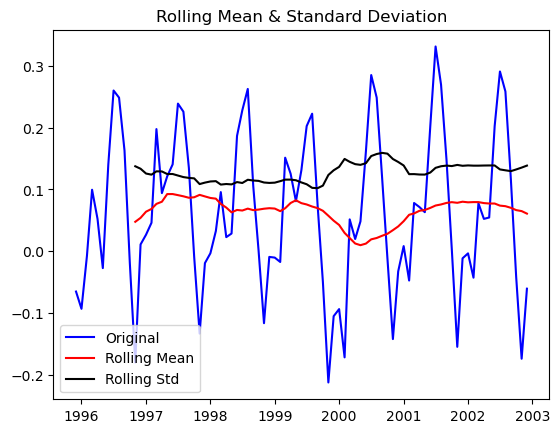

Results of Dickey Fuller Test:
Test Statistic                 -1.910930
p-value                         0.326937
#Lags Used                     12.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


In [25]:
test_stationarity(df_new)

We can see now

      p-value has reduced from 0.99 to 0.022
      Critical values at 1%,5%,10% confidence intervals are pretty close to the Test Statistic
So we can now say that given series is now STATIONARY

#### Time Shift Transformation

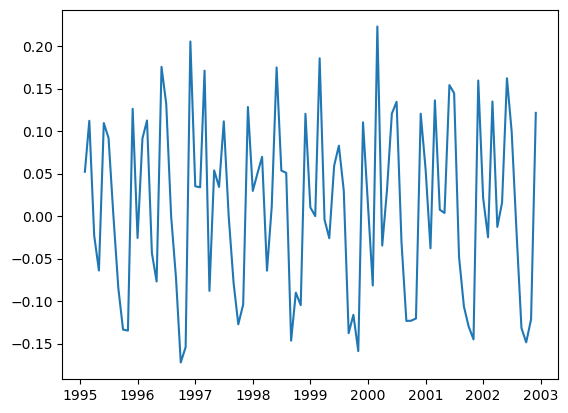

In [26]:
df_log_diff = df1_log - df1_log.shift()
plt.plot(df_log_diff)

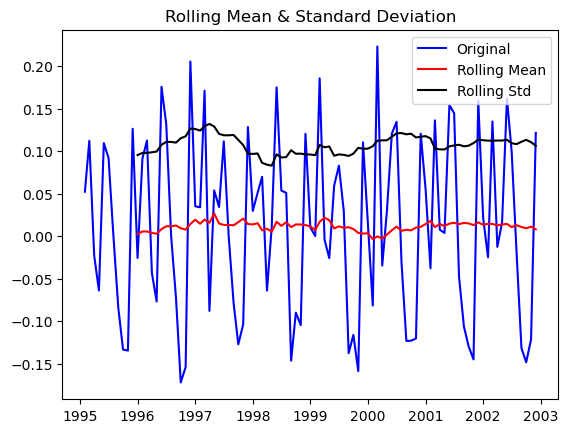

Results of Dickey Fuller Test:


MissingDataError: exog contains inf or nans

In [27]:
test_stationarity(df_log_diff)

p-value of 0.07 is not as good as 0.02 of previous instance.

Test Statistic value not as close to the critical values as that of previous instance.

Let us now break down the 3 components of the log scale series using a system libary function. Once, we separate our the components, 
we can simply ignore trend & seasonality and check on the nature of the residual part.

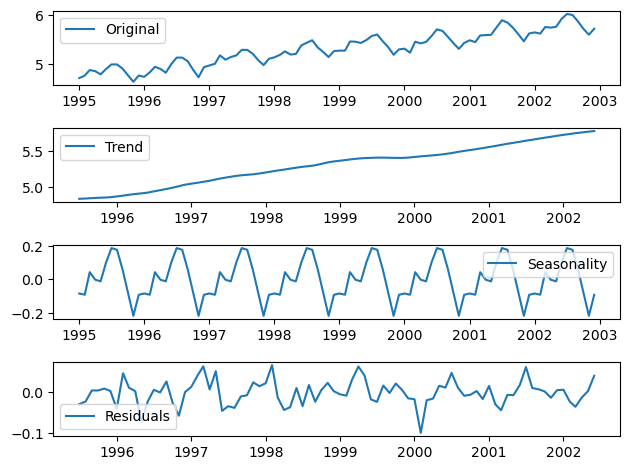

In [29]:
decomposition = seasonal_decompose(df1_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df1_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [30]:
#There can be cases where an observation simply consist of trend & seasonality. 

#In that case, there won't be any residual component & that would be a null or NaN. Hence, we also remove such cases.



df_decompose = residual
df_decompose.dropna(inplace=True)

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

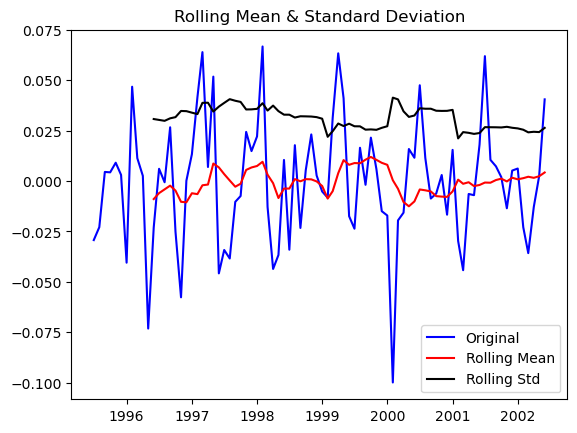

In [31]:
rollmean_decompose = df_decompose.rolling(window=12).mean()
rollstd_decompose = df_decompose.rolling(window=12).std()

plt.plot(df_decompose, color='blue', label='Original')
plt.plot(rollmean_decompose, color='red', label='Rolling Mean')
plt.plot(rollstd_decompose, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

# Plotting ACF & PACF

In [38]:
df_log_diff.dropna(inplace=True)

In [40]:
lag_acf = acf(df_log_diff, nlags=20)
lag_pacf = pacf(df_log_diff, nlags=20, method='ols')

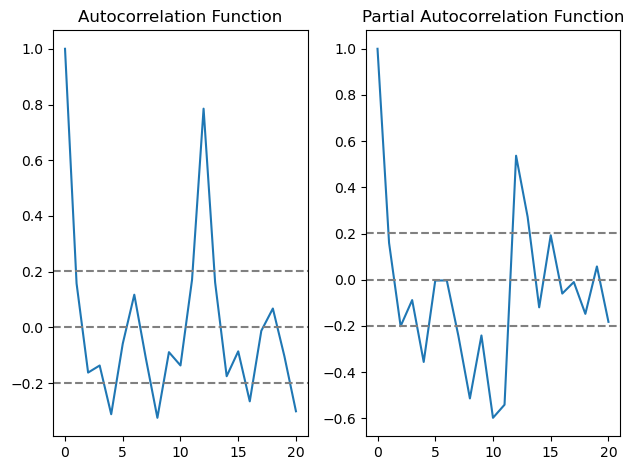

In [42]:
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

From the ACF graph, we can see that curve touches y=0.0 line at x=2. Thus, from theory, Q = 2

From the PACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, P = 2

### AR Model
Making order = (2,1,0) 

In [78]:
#!pip install --upgrade statsmodels

D:\PythnCodes\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\PythnCodes\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\PythnCodes\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


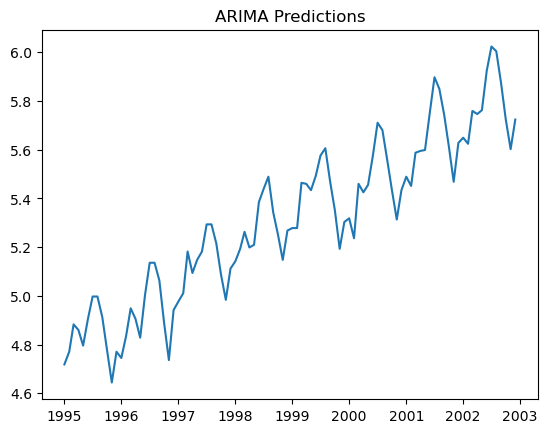

In [52]:
# Fit the ARIMA model
model2 = ARIMA(df1_log, order=(0, 1, 2))
results_MA = model2.fit()

# Get the differenced values from the ARIMA model
fitted_values_diff = results_MA.fittedvalues

# Reverse the differencing to obtain the predicted values
fitted_values = df1_log.shift(1)
fitted_values.iloc[0] = df1_log.iloc[0]
fitted_values = fitted_values + fitted_values_diff

# Plot the original data and the predicted values
plt.plot(df1_log)
plt.plot(fitted_values, color='red')
plt.title('ARIMA Predictions')
plt.show()


In [54]:
predictions_ARIMA_diff = pd.Series(fitted_values_diff, copy=True)
predictions_ARIMA_diff.head()

Month
1995-01-01    0.000000
1995-02-01    4.718499
1995-03-01    4.775805
1995-04-01    4.881535
1995-05-01    4.825743
dtype: float64

In [55]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1995-01-01     0.000000
1995-02-01     4.718499
1995-03-01     9.494304
1995-04-01    14.375839
1995-05-01    19.201582
dtype: float64

In [74]:
predictions_ARIMA_log = pd.Series(df1_log['Passengers'].iloc[0], index=df1_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.tail()

Month
2002-08-01    485.281495
2002-09-01    491.257173
2002-10-01    497.108396
2002-11-01    502.844492
2002-12-01    508.465855
dtype: float64

In [77]:
#We have 96 (existing data of 12 yrs in months) data points. 
#Now, we want to forecast for additional 10 yrs (10x12 months=120 data points).
#96+120=216

pred=results_MA.predict(1,216)
pred.tail()

2012-09-01    5.750588
2012-10-01    5.750588
2012-11-01    5.750588
2012-12-01    5.750588
2013-01-01    5.750588
Freq: MS, Name: predicted_mean, dtype: float64